In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

In [2]:
import airtable as at
import json

In [3]:
with open('api.json') as json_file:
    ak = json.load(json_file)


In [4]:
api_key = ak['key']
base_key = "appx3e9Przn9iprkU"
organizations_table = "Organizations"
projects_table = "Projects"

In [5]:
orgs = at.Airtable(base_key, organizations_table, api_key)
org_fields = ["Uses project (staging for Instances)", "Organization name"]
daos = orgs.get_all(view = 'DAOs in the Wild v2',sort ='Organization name', fields = org_fields)

projs = at.Airtable(base_key, projects_table, api_key)
proj_fields = ["Project name"]
tools = projs.get_all(view = 'OSS governance', sort ='Project name', fields = proj_fields)

In [6]:
daos[0]

{'id': 'recR4Tf4XWOc6RII4',
 'fields': {'Organization name': '/r/ethtrader',
  'Uses project (staging for Instances)': ['recTLikaQcam7XT6J']},
 'createdTime': '2020-08-11T21:08:14.000Z'}

In [7]:
tools[0]

{'id': 'recpnVuaGssc3G05f',
 'fields': {'Project name': '1Hive Gardens'},
 'createdTime': '2020-07-01T15:48:35.000Z'}

In [8]:
daos[0]['fields']['Uses project (staging for Instances)']

['recTLikaQcam7XT6J']

In [9]:
for d in daos[:3]:
    print(d)
    print(d['fields']['Uses project (staging for Instances)'])
    print(len(d['fields']['Uses project (staging for Instances)']))
    print('')

{'id': 'recR4Tf4XWOc6RII4', 'fields': {'Organization name': '/r/ethtrader', 'Uses project (staging for Instances)': ['recTLikaQcam7XT6J']}, 'createdTime': '2020-08-11T21:08:14.000Z'}
['recTLikaQcam7XT6J']
1

{'id': 'recxhL8QqbWOKzwu8', 'fields': {'Organization name': '1Hive', 'Uses project (staging for Instances)': ['recTLikaQcam7XT6J', 'rec2aM39btP3k6DRC', 'recijAqJh9rxY9MvH', 'rec8rCOyDwcwrT95S', 'recRJTkqk5uAagiMR', 'recHncqDiLal7GAPm', 'reca46I0TM3JSABJx', 'rec30pawOK8rt6ZjR', 'recGa1fVGsK8j2wDT']}, 'createdTime': '2020-08-11T21:08:14.000Z'}
['recTLikaQcam7XT6J', 'rec2aM39btP3k6DRC', 'recijAqJh9rxY9MvH', 'rec8rCOyDwcwrT95S', 'recRJTkqk5uAagiMR', 'recHncqDiLal7GAPm', 'reca46I0TM3JSABJx', 'rec30pawOK8rt6ZjR', 'recGa1fVGsK8j2wDT']
9

{'id': 'reccEp6IXzucOpy3A', 'fields': {'Organization name': '1UP World', 'Uses project (staging for Instances)': ['rectOPIzuwyF7zqtE', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'rec30pawOK8rt6ZjR']}, 'createdTime': '2020-08-11T21:08:14.000Z'}
['rectOPIzuw

In [10]:
#trim the data set and get a list of DAOs based on which ones have tool use data
my_daos = []
my_tool_ids = []
for d in daos:
     if 'Uses project (staging for Instances)' in d['fields'].keys():
         my_dao_id = d['id']
         my_dao_name = d['fields']['Organization name']
         my_dao_tools = d['fields']['Uses project (staging for Instances)']

         my_dao_record = {'id':my_dao_id, 'name':my_dao_name, 'tools':my_dao_tools }

         my_daos.append(my_dao_record)

         for t in my_dao_tools:
             if t not in my_tool_ids:
                 my_tool_ids.append(t)


In [11]:
my_tools = []

for t in tools:
    if t['id'] in my_tool_ids:
        my_tool_id = t['id']
        my_tool_name = t['fields']['Project name']

        my_tool_record = {'id':my_tool_id, 'name':my_tool_name}

        my_tools.append(my_tool_record)

In [12]:
my_tools

[{'id': 'recTLikaQcam7XT6J', 'name': 'Aragon'},
 {'id': 'recijAqJh9rxY9MvH', 'name': 'cadCAD'},
 {'id': 'rec2aM39btP3k6DRC', 'name': 'Conviction Voting'},
 {'id': 'rectOPIzuwyF7zqtE', 'name': 'DAOstack'},
 {'id': 'recon8w3CwntZZe7a', 'name': 'Discourse'},
 {'id': 'reca46I0TM3JSABJx', 'name': 'Keybase'},
 {'id': 'recGa1fVGsK8j2wDT', 'name': 'SourceCred'},
 {'id': 'recNcDf0XmUREEEvp', 'name': 'Tezos'}]

In [13]:
#DAOs as a dataframe
ddf = pd.DataFrame(my_daos)
tdf = pd.DataFrame(my_tools)

In [14]:
tdf.head()

,id,name
0,recTLikaQcam7XT6J,Aragon
1,recijAqJh9rxY9MvH,cadCAD
2,rec2aM39btP3k6DRC,Conviction Voting
3,rectOPIzuwyF7zqtE,DAOstack
4,recon8w3CwntZZe7a,Discourse


In [15]:
#initialize a networkx object
G = nx.DiGraph()

#method to add a tool
def add_tool(g, r):
    '''
    g is networkx DiGraph()
    r is a record from the my_tools
    '''
    nid = r['id']
    g.add_node(nid)
    
    g.nodes[nid]['type']='tool'
    g.nodes[nid]['name'] = r['name']

#method to add an org (and tools it uses)
def add_org(g, r, tool_airtable = projs):
    '''
    g is networkx DiGraph()
    r is a record from my_daos
    '''
    nid = r['id']
    g.add_node(nid)
    
    g.nodes[nid]['type']='org'
    g.nodes[nid]['name'] = r['name']

    tids = r['tools']

    for tid in tids:
        if tid in g.nodes:
            g.add_edge(nid, tid)
            g.edges[nid,tid]['type'] = 'user'
        else:
            g.add_node(tid)
            g.nodes[tid]['type']='tool'

            t_data = tool_airtable.get(tid)

            g.nodes[tid]['name'] = t_data['fields']['Project name']

for d in my_daos:
    add_org(G, d)


In [16]:
G.nodes

NodeView(('recR4Tf4XWOc6RII4', 'recTLikaQcam7XT6J', 'recxhL8QqbWOKzwu8', 'rec2aM39btP3k6DRC', 'recijAqJh9rxY9MvH', 'rec8rCOyDwcwrT95S', 'recRJTkqk5uAagiMR', 'recHncqDiLal7GAPm', 'reca46I0TM3JSABJx', 'rec30pawOK8rt6ZjR', 'recGa1fVGsK8j2wDT', 'reccEp6IXzucOpy3A', 'rectOPIzuwyF7zqtE', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'rec3nlkptrNQYdnOv', 'recon8w3CwntZZe7a', 'rec3aYbrcxpFZghOE', 'recfGkC3m5G3t6bYt', 'recelwRgEIoTJ8ICJ', 'recMBR7fypzSMO2eB', 'recvfzeECzfp1wWjW', 'recktpsAyCeblvhvO', 'recxnIifnMBdfTcbO', 'recAuyusQJgP1Fb8Q', 'rec2QM9gqB7Y0dsIa', 'recMdeRlMuMofHyZs', 'recsUe4H35TpgI6lJ', 'recHguxXzLnxXte9V', 'recxV84caJxiUcGVw', 'reclhfZ9PXCwnDDCh', 'rec7KGhrJhG0i1VRC', 'recCmfuvd4z7uPhQq', 'rechmaQ1XiduCix2M', 'recHnPjgOFRYgzMy1', 'recdm4N8p5ontJUdD', 'recmQKn9p45tyNyYp', 'recV8qE8sxong5QcI', 'rec5nctrbjyNJGH52', 'recR6vMN6wavJvB85', 'recGMy6CU1ewMviw9', 'rec46C3X6IhVj3qKO', 'rec9TUaNF53jWPPno', 'recXKJg3coXm4Q13b', 'recewE9BT2IiLpIeg', 'recCGts9ttyauXJhf', 'recsypeXRh11Rql43', 're

In [17]:
def get_nodes_by_type(g, node_type_selection):
    '''
    Definition:
    Function to extract nodes based by named type
    Parameters:
    g: network x object
    node_type_selection: node type
    Assumptions:
    Returns:
    List column of the desired information as:
    Example:
    proposals = get_nodes_by_type(network, 'proposal')
    '''
    return [node for node in g.nodes if g.nodes[node]['type']== node_type_selection ]

In [18]:
dao_nodes = get_nodes_by_type(G, 'org')
n = len(dao_nodes)

tool_nodes = get_nodes_by_type(G, 'tool')
m = len(tool_nodes)

In [19]:
pos = {}
labels = {}

for i in range(n):
    d = dao_nodes[i]
    pos[d] = [0, i]

    try:
        labels[d] = G.nodes[d]['name']
    except:
        labels[d] = d

for j in range(m):
    t = tool_nodes[j]
    pos[t] = [1, j+(n-m)/2]

    try:
        labels[t] = G.nodes[t]['name']
    except:
        labels[t] = t

Text(0.5, 1.0, 'Graph View of Tools Used by DAOs in the Wild')

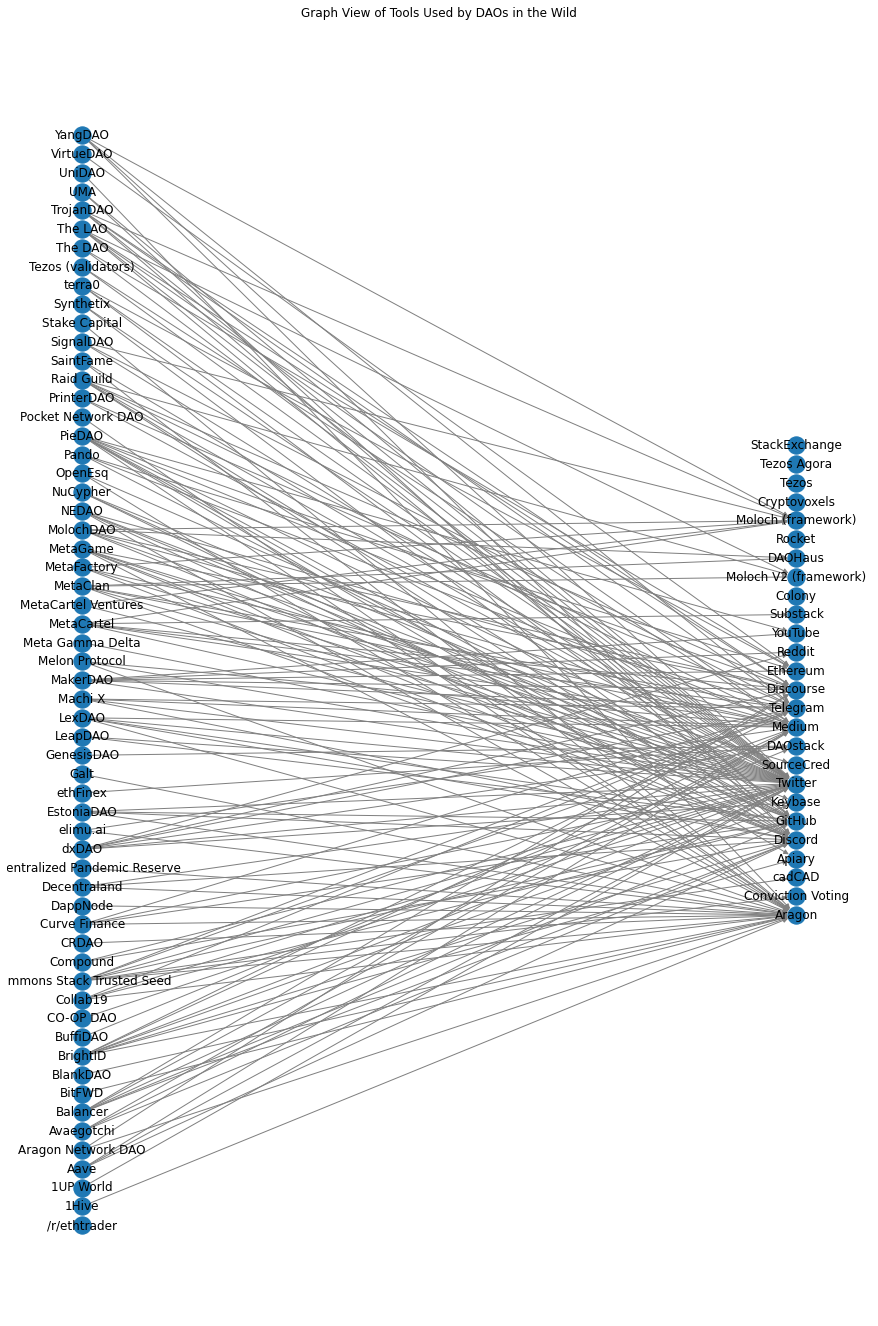

In [20]:
plt.figure(figsize=(12, 18))
nx.draw(G, pos, labels=labels, edge_color = 'gray')
plt.title('Graph View of Tools Used by DAOs in the Wild')

## Next steps
- exploratory data analysis on this data steps

In [21]:
def includes(list, tool):
    return bool(tool in list)

In [22]:
aragon_tool_id = 'recTLikaQcam7XT6J'
ddf['aragon'] = ddf.tools.apply(lambda x: includes(x, aragon_tool_id))

In [23]:
orgs_using_aragon = ddf[ddf.aragon].id.values

In [24]:
len(orgs_using_aragon)

26

In [25]:
co_use = []
for l in ddf[ddf.aragon].tools.values:
    co_use = l + co_use

co_use = list(set(co_use))

In [26]:
len(co_use)

14

In [27]:
asg_nodes = list(orgs_using_aragon)+co_use
asg = G.subgraph(asg_nodes)

In [28]:
asg_labels = {}
for k in labels.keys():
    if k in asg_nodes:
        asg_labels[k] = labels[k]

Text(0.5, 1.0, 'Graph View of Tools Used by DAOs in the Wild')

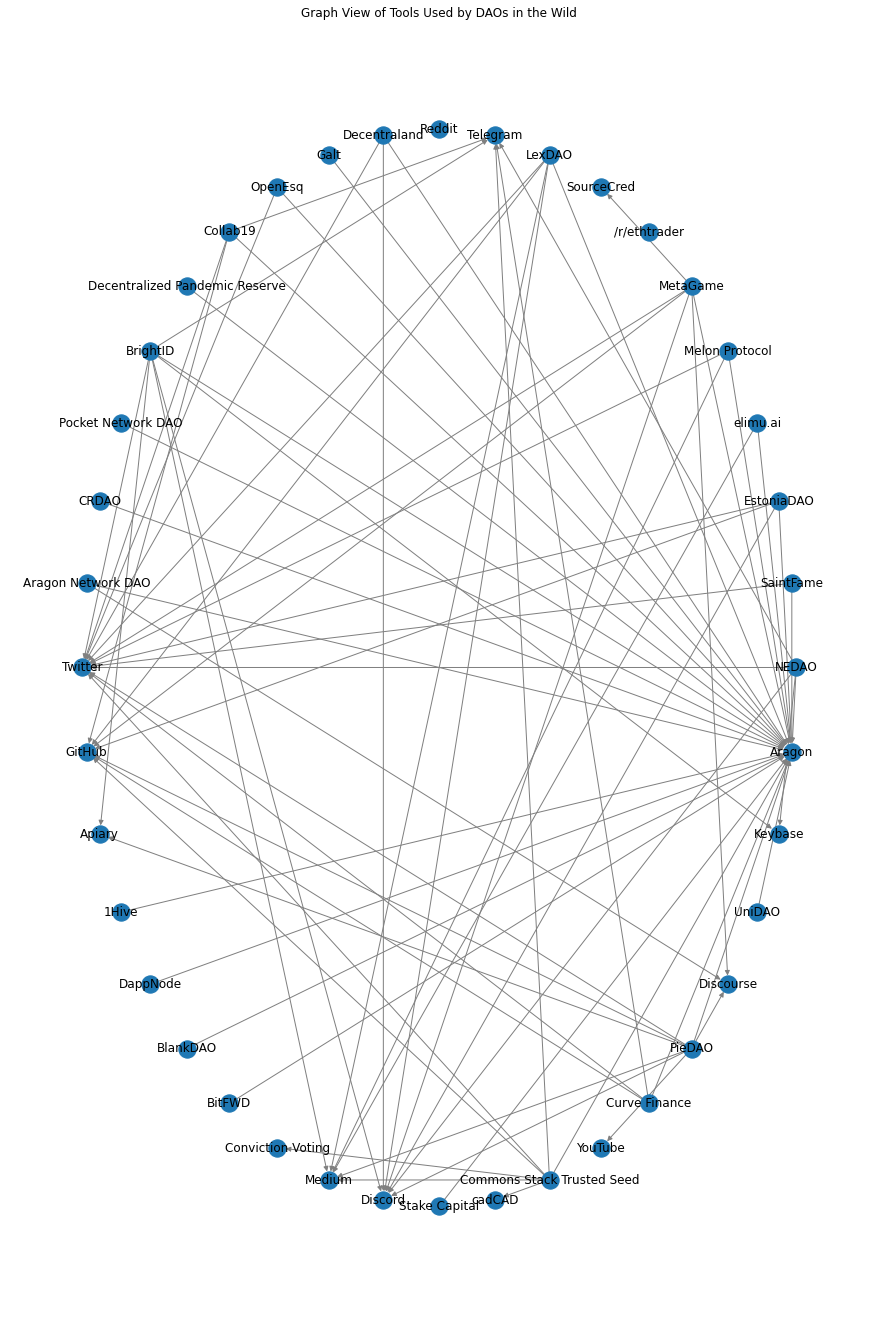

In [29]:
plt.figure(figsize=(12, 18))
nx.draw_circular(asg, labels=asg_labels, edge_color = 'gray')
plt.title('Graph View of Tools Used by DAOs in the Wild')

In [30]:
list(ddf[ddf.id == 'recxhL8QqbWOKzwu8'].tools.values)[0]

['recTLikaQcam7XT6J',
 'rec2aM39btP3k6DRC',
 'recijAqJh9rxY9MvH',
 'rec8rCOyDwcwrT95S',
 'recRJTkqk5uAagiMR',
 'recHncqDiLal7GAPm',
 'reca46I0TM3JSABJx',
 'rec30pawOK8rt6ZjR',
 'recGa1fVGsK8j2wDT']

In [31]:
ddf[ddf.id == 'recxhL8QqbWOKzwu8'].tools.values

array([list(['recTLikaQcam7XT6J', 'rec2aM39btP3k6DRC', 'recijAqJh9rxY9MvH', 'rec8rCOyDwcwrT95S', 'recRJTkqk5uAagiMR', 'recHncqDiLal7GAPm', 'reca46I0TM3JSABJx', 'rec30pawOK8rt6ZjR', 'recGa1fVGsK8j2wDT'])],
      dtype=object)

In [32]:
co_use

['rec30pawOK8rt6ZjR',
 'recHguxXzLnxXte9V',
 'rec2aM39btP3k6DRC',
 'recHncqDiLal7GAPm',
 'rec8rCOyDwcwrT95S',
 'recTLikaQcam7XT6J',
 'recxV84caJxiUcGVw',
 'recijAqJh9rxY9MvH',
 'recon8w3CwntZZe7a',
 'recGa1fVGsK8j2wDT',
 'rectjqMULWohD6jFn',
 'recYxW89TiCDVKazv',
 'reca46I0TM3JSABJx',
 'recRJTkqk5uAagiMR']

In [33]:
ano = len(orgs_using_aragon)
ant = len(co_use)

data = np.empty((ano,ant))
for i in range(ano):
    org = orgs_using_aragon[i]
    use = list(ddf[ddf.id == org].tools.values)[0]
    print(org)
    print(use)
    for j in range(ant):
        tool = co_use[j]
        data[i,j] = bool(tool in use)



recR4Tf4XWOc6RII4
['recTLikaQcam7XT6J']
recxhL8QqbWOKzwu8
['recTLikaQcam7XT6J', 'rec2aM39btP3k6DRC', 'recijAqJh9rxY9MvH', 'rec8rCOyDwcwrT95S', 'recRJTkqk5uAagiMR', 'recHncqDiLal7GAPm', 'reca46I0TM3JSABJx', 'rec30pawOK8rt6ZjR', 'recGa1fVGsK8j2wDT']
rec3aYbrcxpFZghOE
['recTLikaQcam7XT6J', 'recon8w3CwntZZe7a']
recvfzeECzfp1wWjW
['recTLikaQcam7XT6J']
recktpsAyCeblvhvO
['recTLikaQcam7XT6J']
recxnIifnMBdfTcbO
['recTLikaQcam7XT6J', 'rec8rCOyDwcwrT95S', 'rectjqMULWohD6jFn', 'recRJTkqk5uAagiMR', 'reca46I0TM3JSABJx', 'recYxW89TiCDVKazv', 'rec30pawOK8rt6ZjR']
recMdeRlMuMofHyZs
['recTLikaQcam7XT6J', 'recHncqDiLal7GAPm', 'recYxW89TiCDVKazv', 'rec30pawOK8rt6ZjR']
recsUe4H35TpgI6lJ
['recTLikaQcam7XT6J', 'rectjqMULWohD6jFn', 'recHncqDiLal7GAPm', 'recHguxXzLnxXte9V', 'recYxW89TiCDVKazv', 'rec30pawOK8rt6ZjR', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'rec2aM39btP3k6DRC']
recCmfuvd4z7uPhQq
['recTLikaQcam7XT6J']
rechmaQ1XiduCix2M
['recTLikaQcam7XT6J', 'recHncqDiLal7GAPm', 'recYxW89TiCDVKazv', 'rec30pawOK8

'recGa1fVGsK8j2wDT'

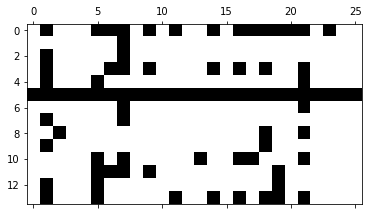

In [34]:
plt.spy(data.T)

In [35]:
def getnames(node_ids):
    print(node_ids)
    return [G.nodes[node_id]['name'] for node_id in node_ids]

['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

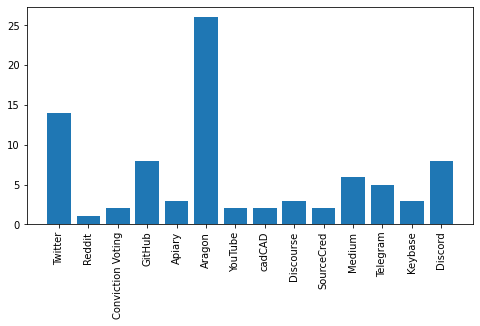

In [36]:
plt.figure(figsize=(8, 4))
plt.bar(getnames(co_use),np.sum(data, axis = 0))
plt.xticks(rotation='vertical')

In [37]:
G.nodes[aragon_tool_id]['name']

'Aragon'

['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'recRxhGQ7BrSshY9t'
 'recBawDYfYBSJxWu1' 'recgCHRGveOl6posb']


<BarContainer object of 26 artists>

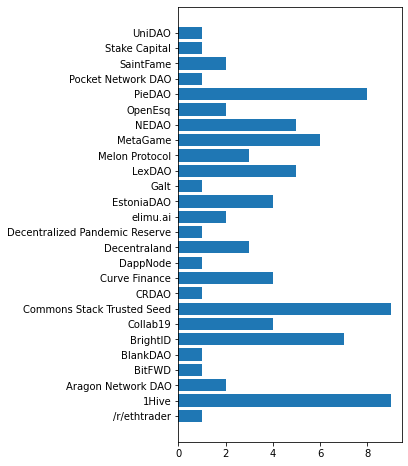

In [38]:
plt.figure(figsize=(4, 8))
plt.barh(getnames(orgs_using_aragon),np.sum(data, axis = 1))

In [39]:
data_df = pd.DataFrame(data, index = getnames(orgs_using_aragon), columns=getnames(co_use) )

['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'recRxhGQ7BrSshY9t'
 'recBawDYfYBSJxWu1' 'recgCHRGveOl6posb']
['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']


In [40]:
import seaborn as sns

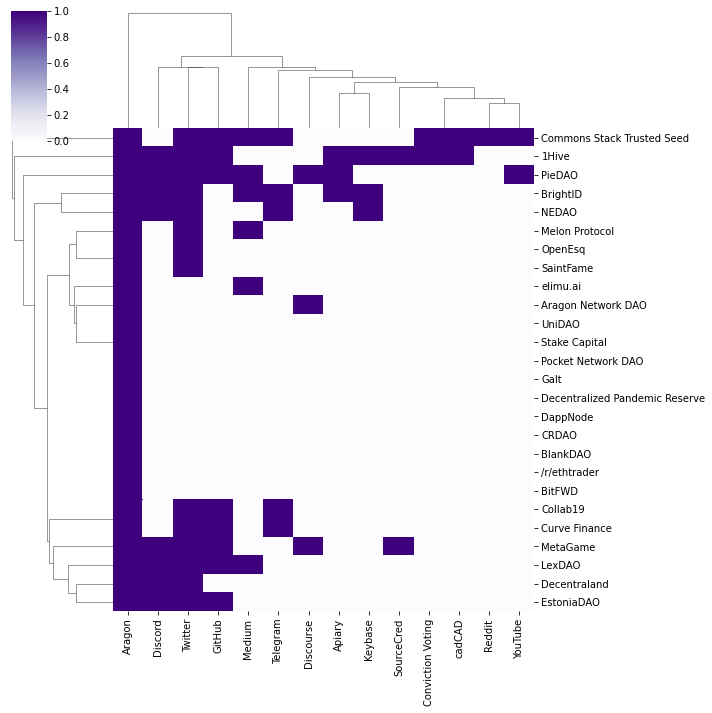

In [41]:
sns.clustermap(data=data_df, cmap = 'Purples')

['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'recRxhGQ7BrSshY9t'
 'recBawDYfYBSJxWu1' 'recgCHRGveOl6posb']
['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'r

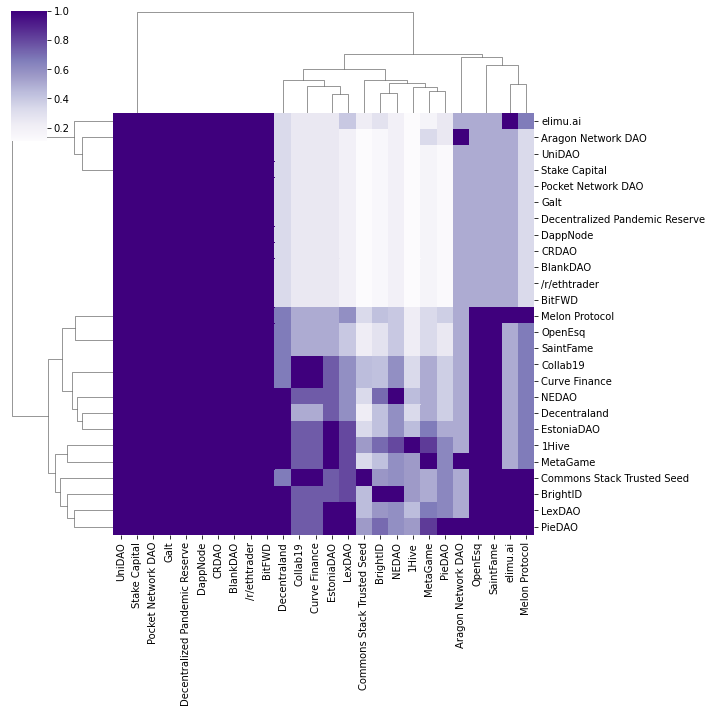

In [42]:
org_data = np.matmul(data,data.T)/np.sum(data, axis=1)


org_data_df = pd.DataFrame(org_data, index = getnames(orgs_using_aragon), columns=getnames(orgs_using_aragon) )
sns.clustermap(data=org_data_df, cmap = 'Purples')

['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'recRxhGQ7BrSshY9t'
 'recBawDYfYBSJxWu1' 'recgCHRGveOl6posb']
['recR4Tf4XWOc6RII4' 'recxhL8QqbWOKzwu8' 'rec3aYbrcxpFZghOE'
 'recvfzeECzfp1wWjW' 'recktpsAyCeblvhvO' 'recxnIifnMBdfTcbO'
 'recMdeRlMuMofHyZs' 'recsUe4H35TpgI6lJ' 'recCmfuvd4z7uPhQq'
 'rechmaQ1XiduCix2M' 'recHnPjgOFRYgzMy1' 'recdm4N8p5ontJUdD'
 'recmQKn9p45tyNyYp' 'rec5nctrbjyNJGH52' 'recR6vMN6wavJvB85'
 'rec46C3X6IhVj3qKO' 'recCGts9ttyauXJhf' 'recPDTUXZDzN9Q6Ge'
 'recvsX3Wm0x2K0rwB' 'recCglCjzevPpJqgV' 'recWeeCqAY2QbrFNL'
 'receypZYHzcgQeE8q' 'rec56K0nZA8Ys0DxM' 'r

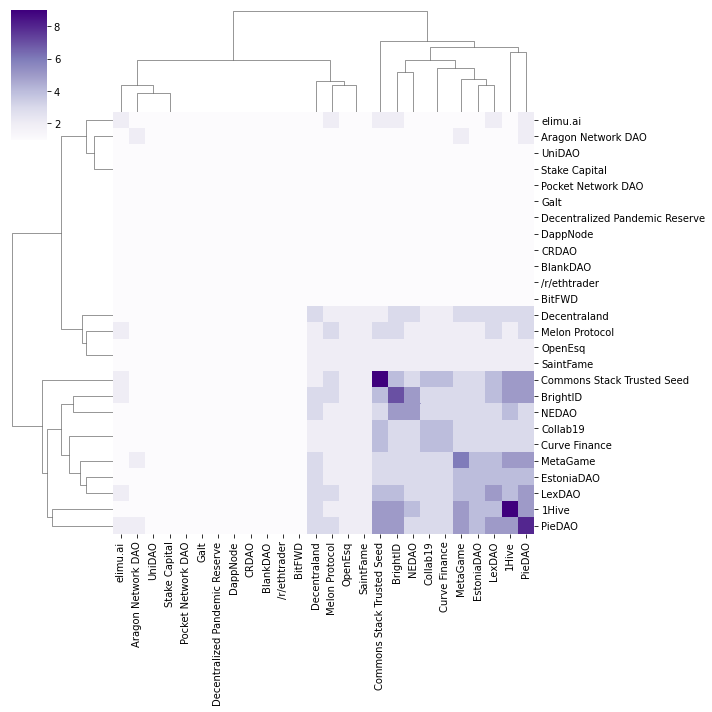

In [43]:
# %%
#normalized
#org_data = np.matmul(data,data.T)/np.sum(data, axis=1)

#unnormalized
org_data = np.matmul(data,data.T)

org_data_df = pd.DataFrame(org_data, index = getnames(orgs_using_aragon), columns=getnames(orgs_using_aragon) )
sns.clustermap(data=org_data_df, cmap = 'Purples')

['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']
['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']


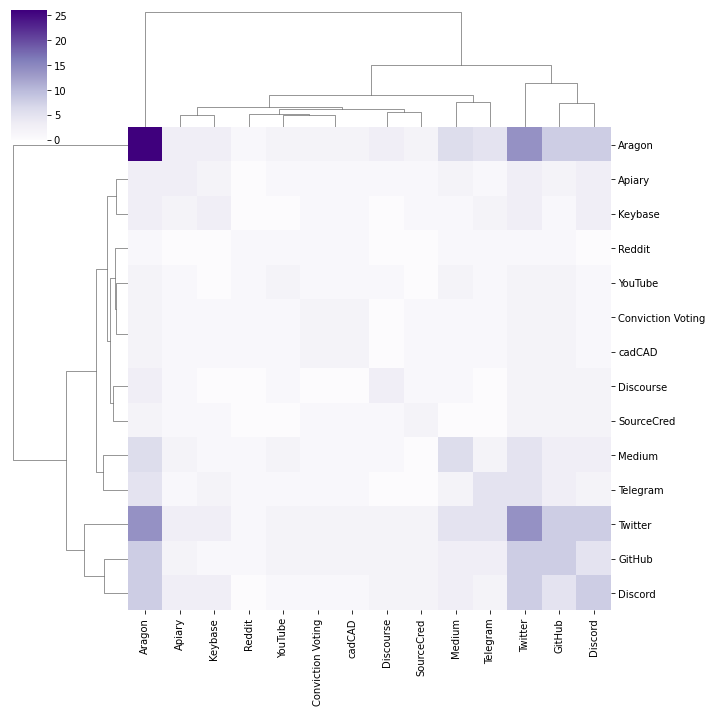

In [44]:
# %%

#normalized
#tool_data = np.matmul(data.T,data)/np.sum(data, axis=0)
#unnormalized
tool_data = np.matmul(data.T,data)


tool_data_df = pd.DataFrame(tool_data, index = getnames(co_use), columns=getnames(co_use) )
sns.clustermap(data=tool_data_df, cmap = 'Purples')

['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']
['rec30pawOK8rt6ZjR', 'recHguxXzLnxXte9V', 'rec2aM39btP3k6DRC', 'recHncqDiLal7GAPm', 'rec8rCOyDwcwrT95S', 'recTLikaQcam7XT6J', 'recxV84caJxiUcGVw', 'recijAqJh9rxY9MvH', 'recon8w3CwntZZe7a', 'recGa1fVGsK8j2wDT', 'rectjqMULWohD6jFn', 'recYxW89TiCDVKazv', 'reca46I0TM3JSABJx', 'recRJTkqk5uAagiMR']


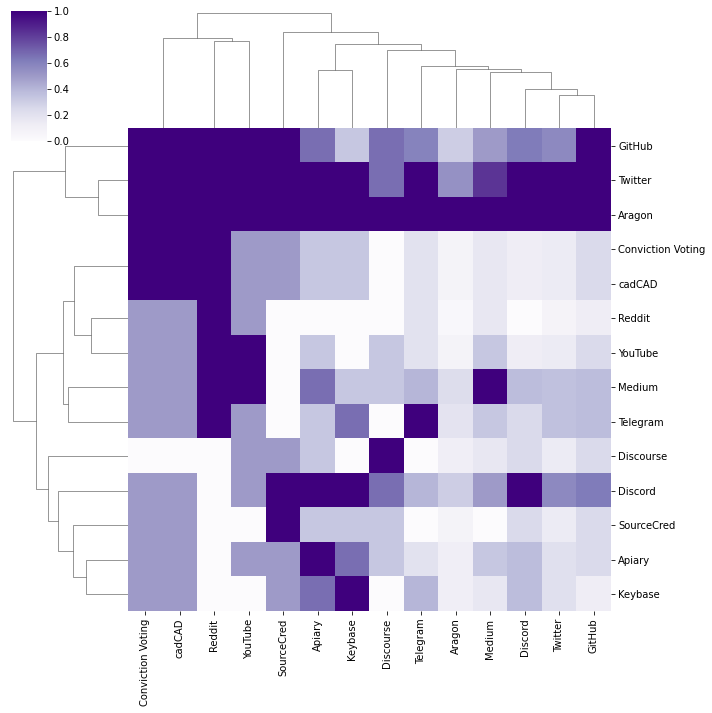

In [45]:
# %%

#normalized
tool_data = np.matmul(data.T,data)/np.sum(data, axis=0)
#unnormalized
#tool_data = np.matmul(data.T,data)


tool_data_df = pd.DataFrame(tool_data, index = getnames(co_use), columns=getnames(co_use) )
sns.clustermap(data=tool_data_df, cmap = 'Purples')

In [46]:
#cleanup incomplete records
data_df.drop('Apiary', axis=1, inplace=True)
data_df.drop('Medium', axis=1, inplace=True)

In [47]:
data_df.drop('Reddit', axis=1, inplace=True)

In [48]:
data_df.drop('YouTube', axis=1, inplace=True)

In [49]:
data_df.drop('Twitter', axis=1, inplace=True)

In [50]:
data_df.index

Index(['/r/ethtrader', '1Hive', 'Aragon Network DAO', 'BitFWD', 'BlankDAO',
       'BrightID', 'Collab19', 'Commons Stack Trusted Seed', 'CRDAO',
       'Curve Finance', 'DappNode', 'Decentraland',
       'Decentralized Pandemic Reserve', 'elimu.ai', 'EstoniaDAO', 'Galt',
       'LexDAO', 'Melon Protocol', 'MetaGame', 'NEDAO', 'OpenEsq', 'PieDAO',
       'Pocket Network DAO', 'SaintFame', 'Stake Capital', 'UniDAO'],
      dtype='object')

In [51]:
flipped = data_df.T

In [52]:
rdf = flipped[['1Hive', 'Aragon Network DAO',
       'BrightID', 'Commons Stack Trusted Seed', 'MetaGame']].T.copy()

In [53]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
Aragon Network DAO,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
BrightID,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [54]:
rdf.columns

Index(['Conviction Voting', 'GitHub', 'Aragon', 'cadCAD', 'Discourse',
       'SourceCred', 'Telegram', 'Keybase', 'Discord'],
      dtype='object')

In [55]:
record = {'cadCAD(org)': {'Conviction Voting':0, 'GitHub':1, 'Discourse':1, 'Telegram':0, 'cadCAD':1,
       'Aragon':1, 'Discord':1, 'Keybase':0, 'SourceCred':0, 'Slack':0, 'BrightID':0}}

In [56]:
rdf = rdf.append(pd.DataFrame(record).T)

In [57]:
rdf['Slack'] = 0.0

In [58]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord,BrightID,Slack
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0
Aragon Network DAO,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0
BrightID,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,0.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,0.0
cadCAD(org),0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [59]:
rdf['BrightID'] = [1.0,0.0, 1.0, 0.0, 0.0, 0.0]

In [60]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord,BrightID,Slack
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Aragon Network DAO,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
BrightID,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
cadCAD(org),0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [61]:
record = {'SourceCred(org)': {'Conviction Voting':0, 'GitHub':1, 'Discourse':1, 'Telegram':0, 'cadCAD':0,
       'Aragon':0, 'Discord':1, 'Keybase':0, 'SourceCred':1, 'Slack':0, 'BrightID':0}}

In [62]:
rdf = rdf.append(pd.DataFrame(record).T)

In [63]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord,BrightID,Slack
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Aragon Network DAO,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
BrightID,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
cadCAD(org),0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
SourceCred(org),0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [64]:
record = {'BlockScience': {'Conviction Voting':0, 'GitHub':1, 'Discourse':0, 'Telegram':0, 'cadCAD':1,
       'Aragon':0, 'Discord':0, 'Keybase':0, 'SourceCred':0, 'Slack':1, 'BrightID':0}}

rdf = rdf.append(pd.DataFrame(record).T)

In [65]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord,BrightID,Slack
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Aragon Network DAO,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
BrightID,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
cadCAD(org),0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
SourceCred(org),0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
BlockScience,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [66]:
rdf.GitHub=1.0

In [67]:
rdf = rdf.fillna(0)

In [68]:
rdf

,Conviction Voting,GitHub,Aragon,cadCAD,Discourse,SourceCred,Telegram,Keybase,Discord,BrightID,Slack
1Hive,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
Aragon Network DAO,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
BrightID,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
Commons Stack Trusted Seed,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
MetaGame,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
cadCAD(org),0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
SourceCred(org),0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
BlockScience,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Text(32.99999999999999, 0.5, 'Organization')

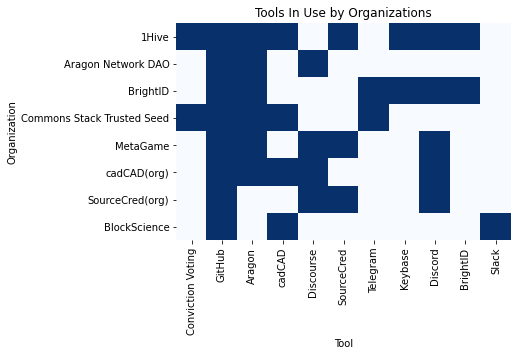

In [69]:
sns.heatmap(data=rdf, cmap = 'Blues', cbar=False)
plt.title('Tools In Use by Organizations')
plt.xlabel('Tool')
plt.ylabel('Organization')

In [70]:
rdf_data = rdf.values
rdf_cols = rdf.columns
rdf_ind = rdf.index

In [71]:
A = np.matmul(rdf_data.T, rdf_data)
D = np.diag(np.diag(A))

In [72]:
A

array([[2., 2., 2., 2., 0., 1., 1., 1., 1., 1., 0.],
       [2., 8., 6., 4., 4., 3., 2., 2., 5., 2., 1.],
       [2., 6., 6., 3., 3., 2., 2., 2., 4., 2., 0.],
       [2., 4., 3., 4., 1., 1., 1., 1., 2., 1., 1.],
       [0., 4., 3., 1., 4., 2., 0., 0., 3., 0., 0.],
       [1., 3., 2., 1., 2., 3., 0., 1., 3., 1., 0.],
       [1., 2., 2., 1., 0., 0., 2., 1., 1., 1., 0.],
       [1., 2., 2., 1., 0., 1., 1., 2., 2., 2., 0.],
       [1., 5., 4., 2., 3., 3., 1., 2., 5., 2., 0.],
       [1., 2., 2., 1., 0., 1., 1., 2., 2., 2., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.]])

In [73]:
D

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 8., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 6., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [74]:
L = np.matmul(np.linalg.inv(D),A)

In [75]:
L

array([[1.        , 1.        , 1.        , 1.        , 0.        ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.        ],
       [0.25      , 1.        , 0.75      , 0.5       , 0.5       ,
        0.375     , 0.25      , 0.25      , 0.625     , 0.25      ,
        0.125     ],
       [0.33333333, 1.        , 1.        , 0.5       , 0.5       ,
        0.33333333, 0.33333333, 0.33333333, 0.66666667, 0.33333333,
        0.        ],
       [0.5       , 1.        , 0.75      , 1.        , 0.25      ,
        0.25      , 0.25      , 0.25      , 0.5       , 0.25      ,
        0.25      ],
       [0.        , 1.        , 0.75      , 0.25      , 1.        ,
        0.5       , 0.        , 0.        , 0.75      , 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.66666667, 0.33333333, 0.66666667,
        1.        , 0.        , 0.33333333, 1.        , 0.33333333,
        0.        ],
       [0.5       , 1.        , 1.        , 0.5       , 0.

In [76]:
rdf_normed = pd.DataFrame(L, columns=rdf_cols, index=rdf_cols)

Text(0.5, 1.0, 'Rates of Mutual Use for Tools')

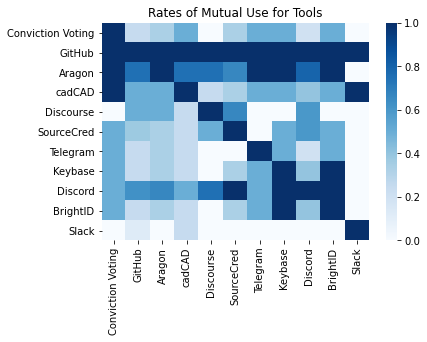

In [77]:
sns.heatmap(data=rdf_normed.T, cmap = 'Blues', )
plt.title('Rates of Mutual Use for Tools')

In [78]:
#